If a dataset is present, features and calculated statistics relevant to the problem
have been reported and discussed, along with a sampling of the data.
In lieu of a dataset, a thorough description of the input space or input data has been made. 
Abnormalities or characteristics of the data or input that need to be addressed have been identified.
A visualization has been provided that summarizes or extracts a relevant characteristic or feature
about the dataset or input data with thorough discussion. Visual cues are clearly defined.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [4]:
# select 2014-2020
vix_raw = pd.read_csv("VIX_History.csv", index_col = 0)
vix_raw.index = pd.to_datetime(vix_raw.index)
# we want to predict close price
vix_raw = vix_raw[(vix_raw.index.year > 2013) & (vix_raw.index.year < 2020)]['CLOSE']
vix_log = np.log(vix_raw)
# since VIX is an index calculated by CBOE, 
# this csv (from CBOE) contains all values of VIX and there is no need to backfill

# no nulls
print(vix_raw.isnull().sum())

0


(array([380., 624., 261., 144.,  53.,  32.,  10.,   2.,   3.,   1.]),
 array([ 9.14, 12.3 , 15.46, 18.62, 21.78, 24.94, 28.1 , 31.26, 34.42,
        37.58, 40.74]),
 <BarContainer object of 10 artists>)

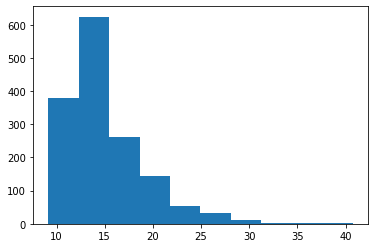

In [5]:
# confirm that raw VIX is heavily skewed to the right -  tail on the right
plt.hist(vix_raw)

(array([121., 265., 441., 314., 159., 119.,  58.,  25.,   4.,   4.]),
 array([2.21266039, 2.36211539, 2.51157039, 2.66102539, 2.8104804 ,
        2.9599354 , 3.1093904 , 3.2588454 , 3.40830041, 3.55775541,
        3.70721041]),
 <BarContainer object of 10 artists>)

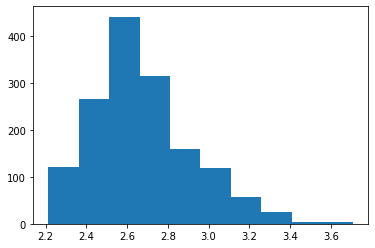

In [6]:
# confirm that log VIX is normally distributed
plt.hist(vix_log)

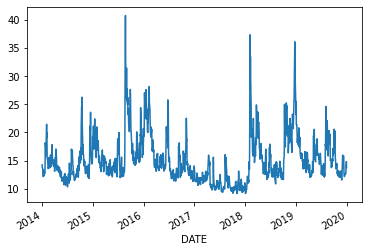

In [7]:
# contrast with raw VIX
vix_raw.plot()
plt.show()

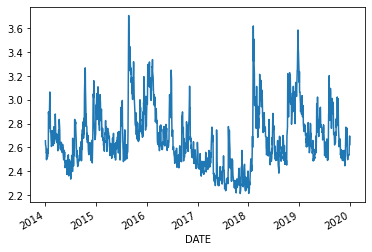

In [8]:
# confirm log VIX is a stationary time series (plot and look for trend and seasonality)
vix_log.plot()
plt.show()

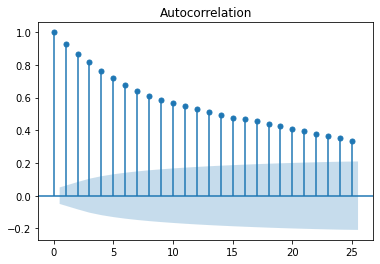

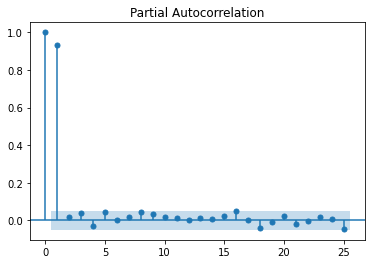

In [9]:
# plot ACF and PACF to offer backing for autoregressiveness
plot_acf(vix_raw, lags=25)
plot_pacf(vix_raw, lags=25)

plt.show()

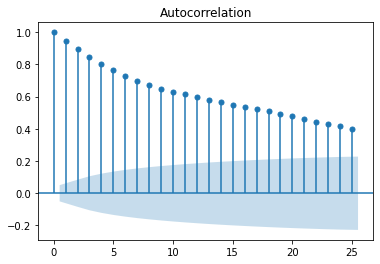

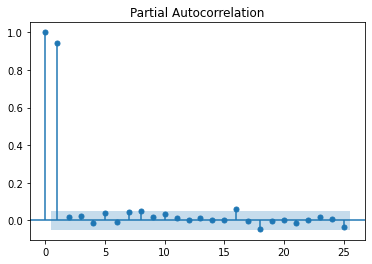

In [10]:
# plot ACF and PACF to offer backing for autoregressiveness
plot_acf(vix_log, lags=25)
plot_pacf(vix_log, lags=25)

plt.show()

In [34]:
# split into train and test

# for HAR, need daily, weekly, monthly averages
vix_har = pd.DataFrame()
vix_har['CLOSE'] = vix_log
vix_har['DAILY'] = vix_log.shift(1)
vix_har['WEEKLY'] = vix_log.rolling(5).mean()
vix_har['MONTHLY'] = vix_log.rolling(16).mean()

vix_har.dropna(inplace=True)

train_har = vix_har[vix_har.index.year <= 2018]
test_har = vix_har[vix_har.index.year == 2019]
print(train_har)
print(test_har)

               CLOSE     DAILY    WEEKLY   MONTHLY
DATE                                              
2014-01-24  2.898119  2.622492  2.629799  2.583091
2014-01-27  2.857619  2.898119  2.697139  2.595733
2014-01-28  2.760010  2.857619  2.738161  2.604373
2014-01-29  2.853593  2.760010  2.798367  2.619824
2014-01-30  2.850128  2.853593  2.843894  2.638033
...              ...       ...       ...       ...
2018-12-24  3.585461  3.404857  3.363925  3.144494
2018-12-26  3.414772  3.585461  3.398517  3.177026
2018-12-27  3.399863  3.414772  3.430128  3.214535
2018-12-28  3.344274  3.399863  3.429846  3.234048
2018-12-31  3.235536  3.344274  3.395981  3.245424

[1243 rows x 4 columns]
               CLOSE     DAILY    WEEKLY   MONTHLY
DATE                                              
2019-01-02  3.145014  3.235536  3.307892  3.245397
2019-01-03  3.236716  3.145014  3.272281  3.252709
2019-01-04  3.062456  3.236716  3.204799  3.251608
2019-01-07  3.063391  3.062456  3.148623  3.251433
2019-0

In [16]:
# for LSTM: past 16 days of data
vix_lstm = pd.DataFrame()
vix_lstm['CLOSE'] = vix_raw/100 # normalize so the numbers are small

for i in range(1, 17):
    vix_lstm[f'{i}_DAYS_AGO'] = vix_lstm['CLOSE'].shift(i)
vix_lstm.dropna(inplace=True)
train_lstm = vix_lstm[vix_lstm.index.year <= 2018]
test_lstm = vix_lstm[vix_lstm.index.year == 2019]
print(train_lstm)
print(test_lstm)

             CLOSE  1_DAYS_AGO  2_DAYS_AGO  3_DAYS_AGO  4_DAYS_AGO  \
DATE                                                                 
2014-01-27  0.1742      0.1814      0.1377      0.1284      0.1287   
2014-01-28  0.1580      0.1742      0.1814      0.1377      0.1284   
2014-01-29  0.1735      0.1580      0.1742      0.1814      0.1377   
2014-01-30  0.1729      0.1735      0.1580      0.1742      0.1814   
2014-01-31  0.1841      0.1729      0.1735      0.1580      0.1742   
...            ...         ...         ...         ...         ...   
2018-12-24  0.3607      0.3011      0.2838      0.2558      0.2558   
2018-12-26  0.3041      0.3607      0.3011      0.2838      0.2558   
2018-12-27  0.2996      0.3041      0.3607      0.3011      0.2838   
2018-12-28  0.2834      0.2996      0.3041      0.3607      0.3011   
2018-12-31  0.2542      0.2834      0.2996      0.3041      0.3607   

            5_DAYS_AGO  6_DAYS_AGO  7_DAYS_AGO  8_DAYS_AGO  9_DAYS_AGO  \
DATE           

In [35]:
# save csvs
train_har.to_csv('train_har.csv')
test_har.to_csv('test_har.csv')

In [17]:
train_lstm.to_csv('train_lstm.csv')
test_lstm.to_csv('test_lstm.csv')